<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Brief-background" data-toc-modified-id="Brief-background-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Brief background</a></span></li><li><span><a href="#Fetch-data" data-toc-modified-id="Fetch-data-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Fetch data</a></span></li><li><span><a href="#Structure-learning" data-toc-modified-id="Structure-learning-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Structure learning</a></span><ul class="toc-item"><li><span><a href="#Discretization" data-toc-modified-id="Discretization-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Discretization</a></span></li></ul></li></ul></div>

# Brief background

To establish causal relationships between development indicators and mixed-migration, we now model the state of the system as a graphical model. A graphical model is a representation of (conditional) dependence of a set of random variables. 

The framework represents the system as a graph, with **nodes** representing state variables (indicators such as GDP, mixed migration, conflict, etc.) and **edges** representing dependency. Given evidence, such a network can be learnt from the data directly (although this is computationally intensive to explore the possible graph structures as the number of state variables increase). This task is one of *structure learning*. 

If a partial set of dependencies are available from experts, based on domain specific insights or field experience, then the structure can be "bootstrapped" with this dependence structure. Such a structure is shown below.

In [1]:
import os
import json
import pandas as pd
import numpy as np
from time import time

from  pomegranate  import BayesianNetwork
import pygraphviz
import networkx
import tempfile

import seaborn as sns
import matplotlib.image as mpl_image
import matplotlib.pyplot as plt

%matplotlib inline 
sns.set(style="white")

# Fetch data

Review the [README.md](../README.md) file on how to download and set up a copy of the pre-processed data. We'll use the [configuration.json](../configuration.json) file to gather all the sources.

In [2]:
start_time = time()
with open("../configuration.json", 'rt') as infile:
    config = json.load(infile)


sources = [os.path.join("..", config['paths']['output'], 
                        d['name'], 
                        'data.csv') for d in config['sources'] if d['name']]


# Generate a data frame with all indicators
df = pd.concat((pd.read_csv(f) for f in sources), sort=False, ignore_index=True)

# Summary stats
print("Sources            : {}".format(len(sources)))
print("Shape              : {} (rows) {} (columns)".format(*df.shape))
print("Geographies        : {}".format(len(df['Country Name'].unique())))
print("Indicators         : {}".format(len(df['Indicator Code'].unique())))
print("Temporal coverage  : {} -> {}".format(df.year.min(), df.year.max()))
print("Null values        : {}".format(sum(df['value'].isnull())))

print("\nLoaded data in {:3.2f} sec.".format(time() - start_time))


# Now arrange data in wide form
data = pd.pivot_table(df, index=['Country Code', 'year'],
                      columns='Indicator Code', values='value')

# Consider country/year as features (and not an index)
data.reset_index(inplace=True)

print("Long form of size  : {} (rows) {} (columns)".format(*data.shape))


subglobal = ['SYR','COL','AFG','COG','SSD','SOM','VEN','ETH','SDN','NGA',
             'IRQ','YEM','UKR','MMR','CAF','CMR','ERI','BDI','GEO','MLI',
             'TCD','LBY','NER','BFA','COD']

Sources            : 19
Shape              : 924558 (rows) 6 (columns)
Geographies        : 568
Indicators         : 142
Temporal coverage  : 1789 -> 2019
Null values        : 1421

Loaded data in 1.47 sec.
Long form of size  : 35901 (rows) 144 (columns)


In [3]:
# data filtering

# Spatial filter
c1 = data['Country Code'].isin(subglobal)

# Temporal filter
c2 = data['year'] >= 1980


data = data[c1 & c2]
print("Filtered data of size  : {} (rows) {} (columns)".format(*data.shape))


Filtered data of size  : 1000 (rows) 144 (columns)


What do the experts think on casuality?

In [4]:
# Model plot
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (20, 20)

def plot_model(model):
    """ Helper function - due to outdated Networkx dependency """
    
    G = pygraphviz.AGraph(directed=True)
    
    G.node_attr['fontsize'] = '20'
    #G.node_attr['fontcolor']='#FFFFFF'
    
    for state in model.states:
        
        G.add_node(state.name, color='blue', shape='circle')

    for parent, child in model.edges:
        G.add_edge(parent.name, child.name, color='blue')
        
    # Remove un-connected nodes
    for n in G.nodes():
        if G.degree(n) == 0:
            G.delete_node(n)
    

    """
    with tempfile.NamedTemporaryFile() as tf:
        G.draw(tf.name, format='png', prog='dot')
        img = mpl_image.imread(tf.name)
        plt.imshow(img)
        plt.axis('off')
        # plt.savefig("test.png")
    """
    with open("test.png", 'wb') as tf:
        G.draw(tf, format='png', prog='dot')
    

def plot_networkx(Q, node_label=None, edge_label=None, filename=None):
    """ Pomegranate requires Networkx 1.11 (outdated) and built in plots don't work """
    
    G = pygraphviz.AGraph(directed=True)

    for state in Q.nodes():
        if node_label:
            G.add_node(state,  label=node_label[state])
        else:
            G.add_node(state)

    for parent, child, data in Q.edges(data=True):
        if edge_label:
            G.add_edge(parent, child, label=data[edge_label])
        else:
            G.add_edge(parent, child)


    #with tempfile.NamedTemporaryFile() as tf:
    with open("img/network.png", 'wb') as tf:
        G.draw(tf, format='png', prog='dot')
        img = mpl_image.imread(tf)
        plt.imshow(img)
        plt.axis('off')
        

In [62]:
def get_constraint_graph(X, plot_net=False):
    """ Read in the user specified constrained network """
    G = networkx.DiGraph()
    cols = X.columns.tolist()

    nodes = {}  # node to ID dictionary

    with open("../model/bayesnetwork/network.json", 'rt') as infile:
        net = json.load(infile)
    indicators = net['indicators']

    # Driver clusters (node sets) from expert-network
    for clus, indicator in net['nodes'].items():

        # build the index sets based on the data
        index = []
        for i in indicator:
            try:
                index.append(cols.index(i))
            except ValueError:
                raise ValueError("{} indicator not in data.".format(i))

        nodes[clus] = index

    # Map the edges
    edge_count = 0
    for clus, to_nodes in net['edges'].items():

        fidx = nodes[clus]

        for tn in to_nodes:

            tidx = nodes[tn]

            if fidx and tidx:

                G.add_edge(tuple(fidx), tuple(tidx))
                edge_count += 1

    print("Domain network with {} node clusters and {} edges.".format(
        len(nodes), edge_count))

    if plot_net:
        nlabels = {tuple(v):k for k, v in nodes.items()}
        plot_networkx(G, node_label=nlabels)
        
    return G, indicators

G, indicators = get_constraint_graph(X, False)

INDICATORS = {i['code']: i['direction-improvement'] for i in indicators}


Domain network with 13 node clusters and 25 edges.


In [71]:
from itertools import product

def get_parent_structure(G, X):
    """ Translates G into the structure of tuple of tuples
    that pomegranate expects.
    A bit convoluted by:
    - G is defined for clusters of nodes, while the structure
    is for indicators
    """
    parentset = {}
    for parent_c, child_c in G.edges:
        for p, c in product(parent_c, child_c):
            try:
                parentset[c].append(p)
            except KeyError:
                parentset[c] = [p]
    
    struct =[]
    for i, c in enumerate(X.columns):
        if i in parentset.keys():
            struct.append(tuple(parentset[i]))
        else:
            struct.append(tuple())
            
    return tuple(struct)

In [72]:
get_parent_structure(G, X)

((),
 (),
 (5,),
 (9, 11, 2, 4),
 (12, 13, 2),
 (),
 (9, 3, 12, 13, 2, 4),
 (9, 3, 12, 13, 2, 4),
 (9, 3, 12, 13, 2, 4),
 (10,),
 (),
 (9, 10),
 (10,),
 (10,),
 (6, 7, 8, 12, 13),
 (9, 11, 3, 6, 7, 8, 12, 13, 2, 14))

((), (), (5,), (9, 11, 2, 4), (12, 13, 2), (), (9, 3, 12, 13, 2, 4), (9, 3, 12, 13, 2, 4), (9, 3, 12, 13, 2, 4), (10,), (), (9, 10), (10,), (10,), (6, 7, 8, 12, 13), (9, 11, 3, 6, 7, 8, 12, 13, 2, 14))


In [43]:
from IPython.display import SVG, display

display(SVG(G.draw(format='svg', prog='dot')))

AttributeError: 'DiGraph' object has no attribute 'draw'

# Structure learning

What is the relationship between these indicators? We start with a simple model for the `subglobal` (25 country) case with no temporal dependence. One limitation on structure learning is that they work for discrete distributions. So we discretize the state variables first. 

## Discretization


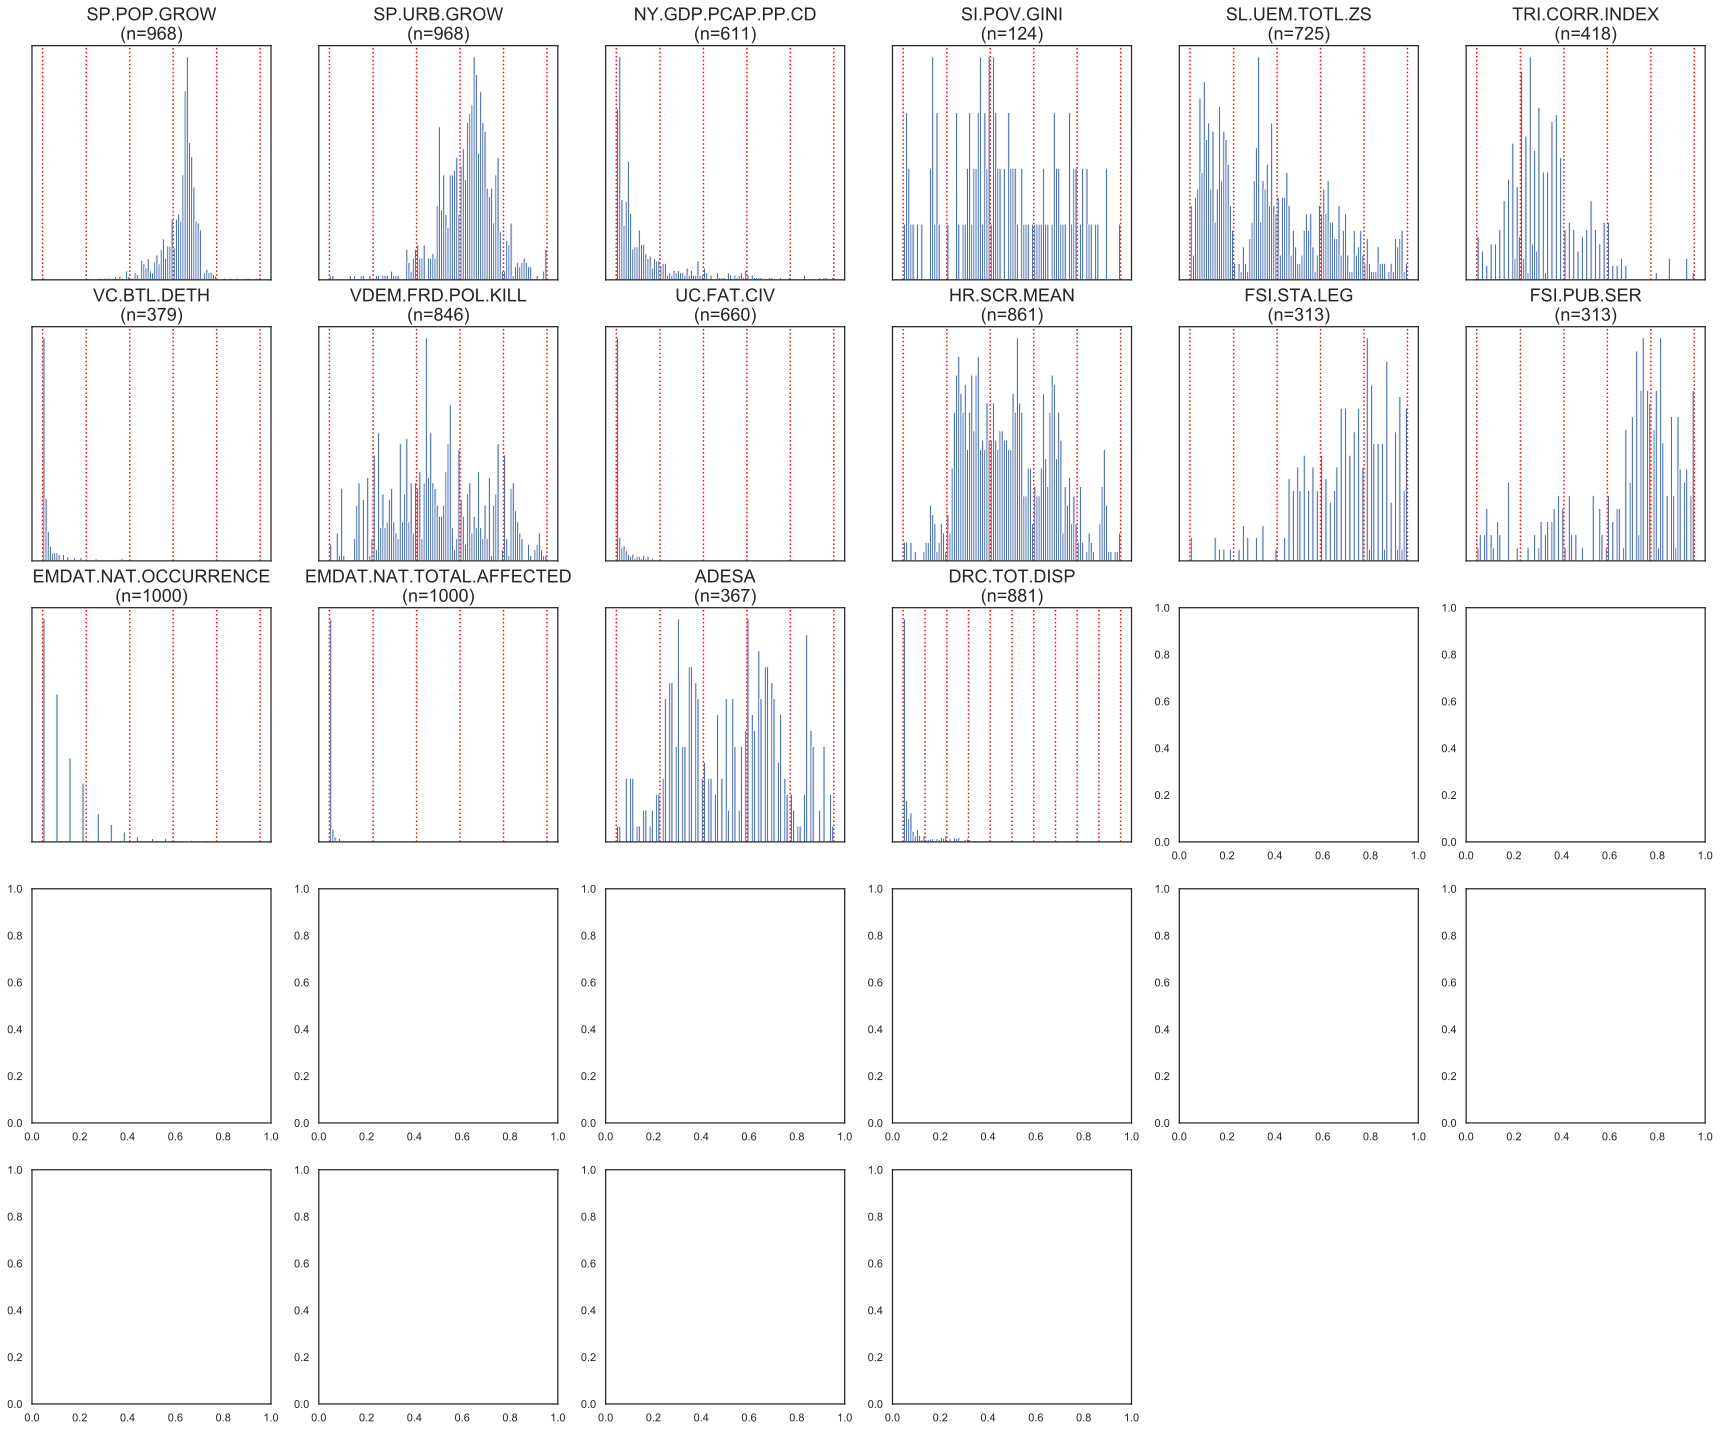

In [17]:
def plot_bins(s, ax, discrete_bins=5, plot_bins=100):
    """ Visualize the raw distribution and bins for indicators """

    
    s.dropna(inplace=True)
    
    # Discretize the series
    _, xbins = pd.cut(s, discrete_bins, retbins=True)
    
    ax.hist(s, bins=plot_bins, density=True)
    ax.set_yticks([], [])
    ax.set_xticks([], [])
    # add reference lines
    [ax.axvline(xb, **{'color': 'red', 'linestyle': 'dotted'}) for xb in xbins]
    
    ax.set_title(s.name + "\n(n={})".format(len(s)), fontsize=18)

from random import sample
cols = [i['code'] for i in indicators]

fig, axes = plt.subplots(5, 6, figsize=(30, 25))

for i, c in enumerate(cols):
    if c.startswith("DRC.TOT"):
        nbins = 10
    else:
        nbins = 5
    
    plot_bins(data[c], discrete_bins= nbins, ax=axes[np.unravel_index(i, axes.shape)])

fig.delaxes(axes[4][4])
fig.delaxes(axes[4][5])
plt.savefig("img/states.png")

In [6]:
# Discretization scheme

LABELS = ['worse', 'poor', 'average', 'good', 'best']


def discretization(x):
    """ Discretize indicators """

    # Target variable has larger number of bins
    if x.name.startswith("DRC.TOT"):
        
        return pd.cut(x, 10).astype(str)

    # Quantile discretization of 5 classes for all other numeric quantities

    try:
        if x.name in INDICATORS.keys():
            print("Column: {}".format(x.name))
        
            if INDICATORS[x.name] == "higher":
                lbl = LABELS
            else:
                lbl = list(reversed(LABELS))
        else:
            # We don't use these labels
            lbl = LABELS

        return pd.qcut(x, 5, labels=lbl, duplicates='drop').astype(str)

    except ValueError:

        # Resort to ranking if data is sparse
        # WARNING: Same values will be discretized to separate bins
        try:
            print("Column: {} +++ Ranked bins".format(x.name))
            return pd.qcut(x.rank(method='first'), 5, labels=lbl, duplicates='drop').astype(str)
        except ValueError:
            print("Column: {} ------------- ERROR.".format(x.name))
            return None

X = data[INDICATORS].apply(discretization, axis=0)
X.dropna(axis=1, how='all', inplace=True)

Column: SP.POP.GROW
Column: SP.POP.GROW
Column: SP.URB.GROW
Column: NY.GDP.PCAP.PP.CD
Column: SI.POV.GINI
Column: SL.UEM.TOTL.ZS
Column: TRI.CORR.INDEX
Column: VC.BTL.DETH
Column: VDEM.FRD.POL.KILL
Column: UC.FAT.CIV
Column: UC.FAT.CIV +++ Ranked bins
Column: HR.SCR.MEAN
Column: FSI.STA.LEG
Column: FSI.PUB.SER
Column: EMDAT.NAT.OCCURRENCE
Column: EMDAT.NAT.OCCURRENCE +++ Ranked bins
Column: EMDAT.NAT.TOTAL.AFFECTED
Column: EMDAT.NAT.TOTAL.AFFECTED +++ Ranked bins
Column: ADESA


In [ ]:
start_time = time()
model = BayesianNetwork.from_samples(X, 
                                     algorithm='greedy',
                                     state_names=X.columns,
                                     constraint_graph=G,
                                     n_jobs=-1)
print("Structure learning (constrained) in {:3.2f} sec.".format(time() - start_time))

In [ ]:
# Load cached model structure
with open("../model.json", 'rt') as infile:
    mj = infile.read()
    
model = BayesianNetwork.from_json(mj)
#plot_model(model)

In [18]:
model.plot(filename="img/bn.png")

In [ ]:
# Get the domain expert network
with open("../model/bayesnetwork/network.json", 'rt') as infile:
    net = json.load(infile)
    
clus = {i: lbl for lbl, indsets in net['nodes'].items() for i in indsets}
    
G = pygraphviz.AGraph(directed=True, strict=False)
for nodes, _ in net['nodes'].items():
    G.add_node(nodes)

for src, destinations in net['edges'].items():
    for des in destinations:
        G.add_edge(src, des, style='dotted', color='red')
        

# Get the learnt structure 
#with open("model.json", 'rt') as infile:
#    mj = infile.read()
    
#model = BayesianNetwork.from_json(mj)
print("Model with {} edges.".format(model.edge_count()))

data_links = []
for parent, child in model.edges:
    
    try:
        i = clus[parent.name]
        
        
        try:
            j = clus[child.name]
            
            if (i, j) not in data_links:
                data_links.append((i, j))
            
        except KeyError:
            G.add_node(child.name)
            data_links.append((i, child.name))
    
    except KeyError:
        
        try:
            j = clus[child.name]
            
            G.add_node(parent.name)
            data_links.append((parent.name, j))
            
        except KeyError:
            
            continue

for i, j in data_links:
    G.add_edge(i, j, style='solid', penwidth='2', color='blue')
    


with open("img/data-vs-expert2.png", 'wb') as tf:
    G.draw(tf, format='png', prog='dot')


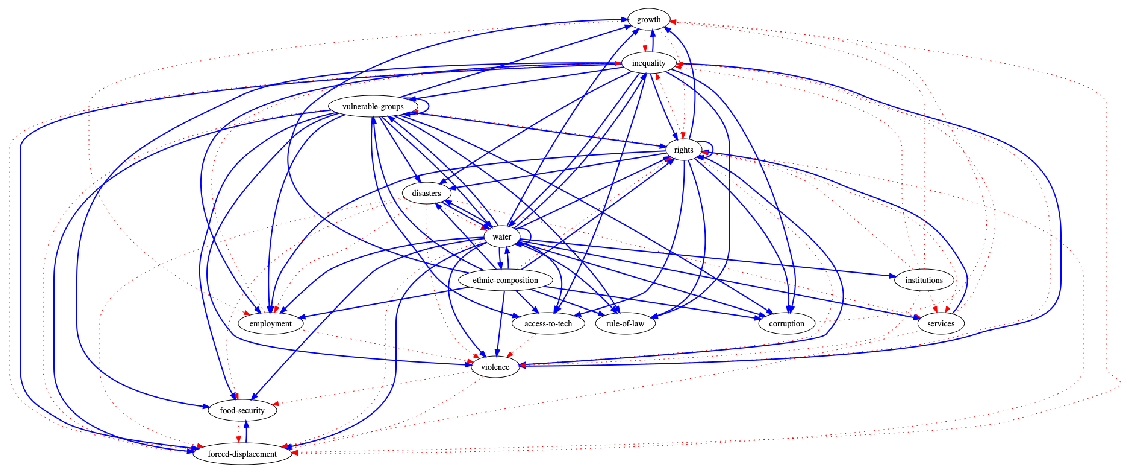

In [10]:
with tempfile.NamedTemporaryFile() as tf:
    G.draw(tf.name, format='png', prog='dot')
    img = mpl_image.imread(tf.name)
    plt.imshow(img)
    plt.axis('off')